<a href="https://colab.research.google.com/github/208sp/Revenue-Generated-by-Advertisement/blob/main/Revenue_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10

#Reading and exploring dataset

In [2]:
train_df=pd.read_csv('https://raw.githubusercontent.com/208sp/Revenue-Generated-by-Advertisement/main/Train_Data.csv')
test_df=pd.read_csv('https://raw.githubusercontent.com/208sp/Revenue-Generated-by-Advertisement/main/Test_Data.csv')

In [3]:
train_df.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [4]:
test_df.head()

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.58,121,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.17,22,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.05,5,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.01,2,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.01,3,1,0


In [5]:
train_df.shape, test_df.shape

((4571, 9), (318, 8))

In [6]:
#adding test and training flag so that we can split train/test data
train_df['tst']=0
test_df['tst']=1

In [7]:
#concatenating train and test data for data preprocessing
data=pd.concat([train_df,test_df],axis=0,copy=True)
data.head()
df=data.copy()

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
impressions,4889.0,90.977705,193.610988,1.0,5.00,16.00,85.00,3239.00
clicks,4889.0,42.454899,97.591346,0.0,2.00,7.00,38.00,1771.00
cost,4889.0,2.643461,13.900229,0.0,0.04,0.19,1.26,531.25
conversions,4889.0,1.304357,5.073662,0.0,0.00,0.00,1.00,94.00
revenue,4571.0,231.865340,1091.742763,0.0,0.00,0.00,92.60,20515.41
tst,4889.0,0.065044,0.246629,0.0,0.00,0.00,0.00,1.00


In [9]:
df.isna().sum()

date             0
campaign         0
adgroup          0
ad               0
impressions      0
clicks           0
cost             0
conversions      0
revenue        318
tst              0
dtype: int64

In [10]:
df[(df.conversions==0)&(df.tst==0)].shape
df

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,0
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,0
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,0
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,0
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,0
...,...,...,...,...,...,...,...,...,...,...
313,15-03-2021,campaign 1,adgroup 4,ad 55,1,1,0.01,0,NaN,1
314,15-03-2021,campaign 1,adgroup 3,ad 55,5,1,0.01,0,NaN,1
315,15-03-2021,campaign 1,adgroup 1,ad 55,25,11,0.14,0,NaN,1
316,15-03-2021,campaign 1,adgroup 3,ad 56,9,4,0.06,0,NaN,1


#Feature Engineering

In [11]:
data['day']=data['date'].apply(lambda x:x[0:2]).astype(int)

data['month']=data['date'].apply(lambda x:x[3:5]).astype(int)

data['year']=pd.DatetimeIndex(data['date']).year
data

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,0,1,8,2020
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,0,1,8,2020
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,0,1,8,2020
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,0,1,8,2020
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,0,1,8,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,15-03-2021,campaign 1,adgroup 4,ad 55,1,1,0.01,0,NaN,1,15,3,2021
314,15-03-2021,campaign 1,adgroup 3,ad 55,5,1,0.01,0,NaN,1,15,3,2021
315,15-03-2021,campaign 1,adgroup 1,ad 55,25,11,0.14,0,NaN,1,15,3,2021
316,15-03-2021,campaign 1,adgroup 3,ad 56,9,4,0.06,0,NaN,1,15,3,2021


In [12]:
data.shape
df=data.copy()
df

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,0,1,8,2020
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,0,1,8,2020
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,0,1,8,2020
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,0,1,8,2020
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,0,1,8,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,15-03-2021,campaign 1,adgroup 4,ad 55,1,1,0.01,0,NaN,1,15,3,2021
314,15-03-2021,campaign 1,adgroup 3,ad 55,5,1,0.01,0,NaN,1,15,3,2021
315,15-03-2021,campaign 1,adgroup 1,ad 55,25,11,0.14,0,NaN,1,15,3,2021
316,15-03-2021,campaign 1,adgroup 3,ad 56,9,4,0.06,0,NaN,1,15,3,2021


In [13]:
df['CPC']=df.cost.divide(df.clicks).replace(np.inf,0).replace(np.nan,0)
df['CTR']=df.clicks.divide(df.impressions).replace(np.inf,0).replace(np.nan,0)
df['COA']=df.cost.divide(df.conversions).replace(np.inf,0).replace(np.nan,0)

In [14]:
df['ad']=df['ad'].str.slice(3).astype(int)

df['adgroup']=df['adgroup'].str.slice(8).astype(int)

df['campaign']=df['campaign'].str.slice(-1).astype(int)

df.reset_index()

,index,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year,CPC,CTR,COA
0,0,01-08-2020,1,1,1,24,6,0.08,0,0.00,0,1,8,2020,0.013333,0.250000,0.0000
1,1,01-08-2020,1,2,1,1,0,0.00,0,0.00,0,1,8,2020,0.000000,0.000000,0.0000
2,2,01-08-2020,1,3,1,13,4,0.04,0,0.00,0,1,8,2020,0.010000,0.307692,0.0000
3,3,01-08-2020,1,4,1,5,4,0.08,0,0.00,0,1,8,2020,0.020000,0.800000,0.0000
4,4,01-08-2020,1,1,2,247,126,1.29,4,925.71,0,1,8,2020,0.010238,0.510121,0.3225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884,313,15-03-2021,1,4,55,1,1,0.01,0,NaN,1,15,3,2021,0.010000,1.000000,0.0000
4885,314,15-03-2021,1,3,55,5,1,0.01,0,NaN,1,15,3,2021,0.010000,0.200000,0.0000
4886,315,15-03-2021,1,1,55,25,11,0.14,0,NaN,1,15,3,2021,0.012727,0.440000,0.0000
4887,316,15-03-2021,1,3,56,9,4,0.06,0,NaN,1,15,3,2021,0.015000,0.444444,0.0000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4889 entries, 0 to 317
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         4889 non-null   object 
 1   campaign     4889 non-null   int64  
 2   adgroup      4889 non-null   int64  
 3   ad           4889 non-null   int64  
 4   impressions  4889 non-null   int64  
 5   clicks       4889 non-null   int64  
 6   cost         4889 non-null   float64
 7   conversions  4889 non-null   int64  
 8   revenue      4571 non-null   float64
 9   tst          4889 non-null   int64  
 10  day          4889 non-null   int64  
 11  month        4889 non-null   int64  
 12  year         4889 non-null   int64  
 13  CPC          4889 non-null   float64
 14  CTR          4889 non-null   float64
 15  COA          4889 non-null   float64
dtypes: float64(5), int64(10), object(1)
memory usage: 649.3+ KB


In [16]:
df.month.unique()

array([ 8,  9, 10, 11, 12,  1,  2,  3])

#Exploratory Data Analysis

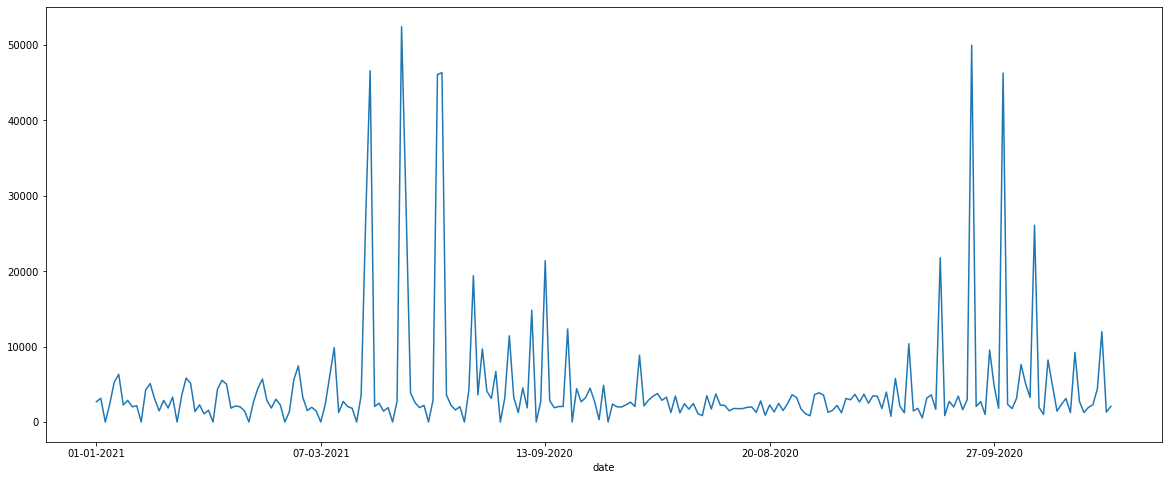

In [17]:
#Time series view
plt.figure(figsize=(20,8))
df.groupby(['date'])['revenue'].sum().plot(kind='line')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


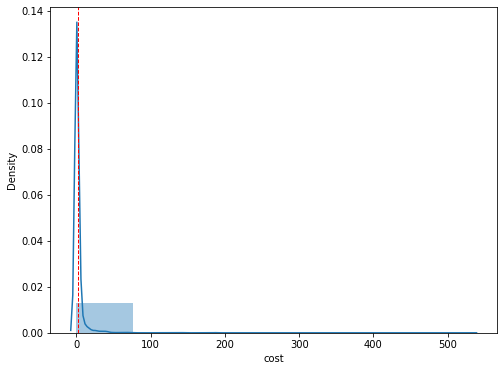

In [18]:
plt.figure(figsize=(8,6))
#plt.hist(df.cost,bins=7,density=True)
sns.distplot(df.cost,bins=7)
plt.axvline(df.cost.mean(), color='r', linestyle='dashed', linewidth=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


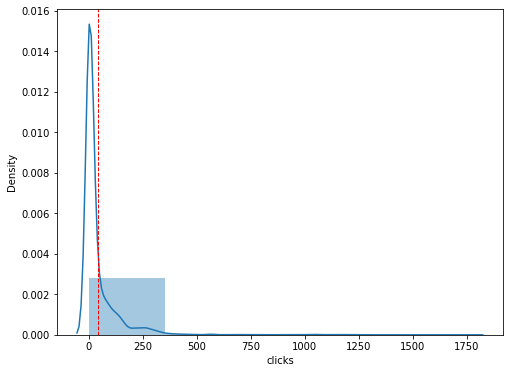

In [19]:
plt.figure(figsize=(8,6))
sns.distplot(df.clicks,bins=5)
plt.axvline(df.clicks.mean(), color='r', linestyle='dashed', linewidth=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


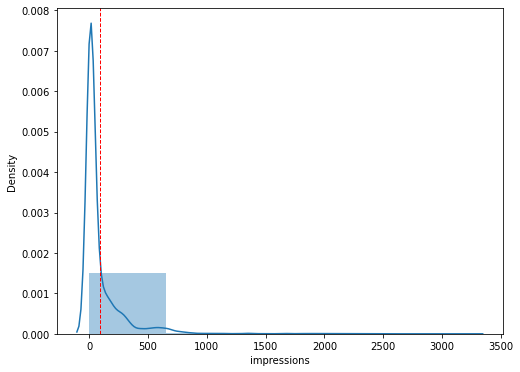

In [20]:
plt.figure(figsize=(8,6))
sns.distplot(df.impressions,bins=5)
plt.axvline(df.impressions.mean(), color='r', linestyle='dashed', linewidth=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


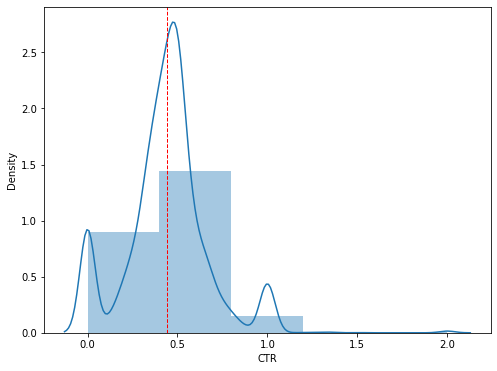

In [21]:
plt.figure(figsize=(8,6))
sns.distplot(df.CTR,bins=5)
plt.axvline(df.CTR.mean(), color='r', linestyle='dashed', linewidth=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


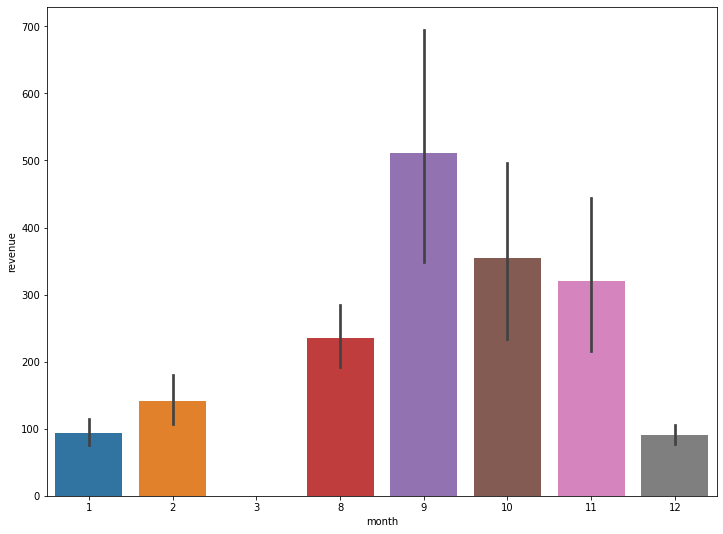

In [22]:
f, ax = plt.subplots(figsize=(12, 9));
sns.barplot('month','revenue',data=df)

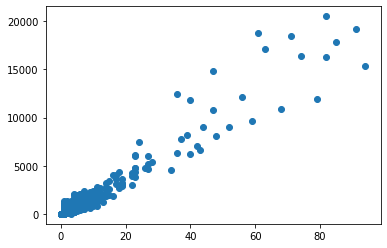

In [23]:
plt.scatter(df.conversions,df.revenue)
plt.show()

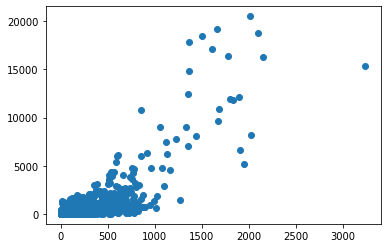

In [24]:
plt.scatter(df.impressions,df.revenue)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


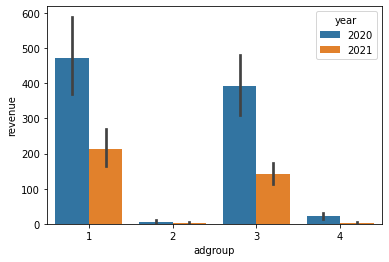

In [25]:
sns.barplot('adgroup','revenue',data=df,hue='year')

In [26]:
df.groupby(['date','adgroup'])['revenue'].sum().sort_values(ascending=False)

date        adgroup
10-10-2020  3          31765.46
26-11-2020  1          29398.31
09-09-2020  3          26956.77
27-11-2020  1          25685.71
09-09-2020  1          24911.10
                         ...   
15-08-2020  2              0.00
15-03-2021  4              0.00
            3              0.00
            2              0.00
31-12-2020  4              0.00
Name: revenue, Length: 908, dtype: float64

In [27]:
list(df.select_dtypes(exclude = ['object','datetime']).drop(columns=['revenue','tst']).columns)

['campaign',
 'adgroup',
 'ad',
 'impressions',
 'clicks',
 'cost',
 'conversions',
 'day',
 'month',
 'year',
 'CPC',
 'CTR',
 'COA']

In [28]:
df_copy=df.copy()

#Feature Transformation and Scaling

In [29]:
str_col=['ad','adgroup','campaign','year','month','day','date']
le=LabelEncoder()
for col in str_col:
    df[col]=le.fit_transform(df[col].values)

In [30]:
sc=MinMaxScaler()
num_col=list(df.select_dtypes(exclude = ['object']).drop(columns=['revenue','tst']).columns)
df_scaled=sc.fit_transform(df[num_col].values)

In [31]:
df_scaled=pd.DataFrame(df_scaled,columns=num_col)
df_scaled.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,day,month,year,CPC,CTR,COA
0,0.013274,0.0,0.000000,0.000000,0.007103,0.003388,0.000151,0.000000,0.0,0.428571,0.0,0.003500,0.125000,0.000000
1,0.013274,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.428571,0.0,0.000000,0.000000,0.000000
2,0.013274,0.0,0.666667,0.000000,0.003706,0.002259,0.000075,0.000000,0.0,0.428571,0.0,0.002625,0.153846,0.000000
3,0.013274,0.0,1.000000,0.000000,0.001235,0.002259,0.000151,0.000000,0.0,0.428571,0.0,0.005249,0.400000,0.000000
4,0.013274,0.0,0.000000,0.013514,0.075973,0.071146,0.002428,0.042553,0.0,0.428571,0.0,0.002687,0.255061,0.005614


In [32]:
df[num_col]

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,day,month,year,CPC,CTR,COA
0,3,0,0,0,24,6,0.08,0,0,3,0,0.013333,0.250000,0.0000
1,3,0,1,0,1,0,0.00,0,0,3,0,0.000000,0.000000,0.0000
2,3,0,2,0,13,4,0.04,0,0,3,0,0.010000,0.307692,0.0000
3,3,0,3,0,5,4,0.08,0,0,3,0,0.020000,0.800000,0.0000
4,3,0,0,1,247,126,1.29,4,0,3,0,0.010238,0.510121,0.3225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,114,0,3,54,1,1,0.01,0,14,2,1,0.010000,1.000000,0.0000
314,114,0,2,54,5,1,0.01,0,14,2,1,0.010000,0.200000,0.0000
315,114,0,0,54,25,11,0.14,0,14,2,1,0.012727,0.440000,0.0000
316,114,0,2,55,9,4,0.06,0,14,2,1,0.015000,0.444444,0.0000


In [33]:
train=df[df.tst==0]
test=df[df.tst==1]

In [34]:
train=train.drop(columns=['tst','campaign'],axis=1)

In [35]:
test=test.drop(columns=['tst','revenue','campaign'],axis=1)
test

,date,adgroup,ad,impressions,clicks,cost,conversions,day,month,year,CPC,CTR,COA
0,2,0,0,121,49,0.58,1,0,2,1,0.011837,0.404959,0.58
1,2,2,0,22,12,0.17,0,0,2,1,0.014167,0.545455,0.00
2,2,3,0,5,3,0.05,0,0,2,1,0.016667,0.600000,0.00
3,2,1,0,2,1,0.01,0,0,2,1,0.010000,0.500000,0.00
4,2,1,1,3,1,0.01,0,0,2,1,0.010000,0.333333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,114,3,54,1,1,0.01,0,14,2,1,0.010000,1.000000,0.00
314,114,2,54,5,1,0.01,0,14,2,1,0.010000,0.200000,0.00
315,114,0,54,25,11,0.14,0,14,2,1,0.012727,0.440000,0.00
316,114,2,55,9,4,0.06,0,14,2,1,0.015000,0.444444,0.00


In [36]:
X=train.columns.drop('revenue')
y=train.revenue
X

Index(['date', 'adgroup', 'ad', 'impressions', 'clicks', 'cost', 'conversions',
       'day', 'month', 'year', 'CPC', 'CTR', 'COA'],
      dtype='object')

#Feature Selection

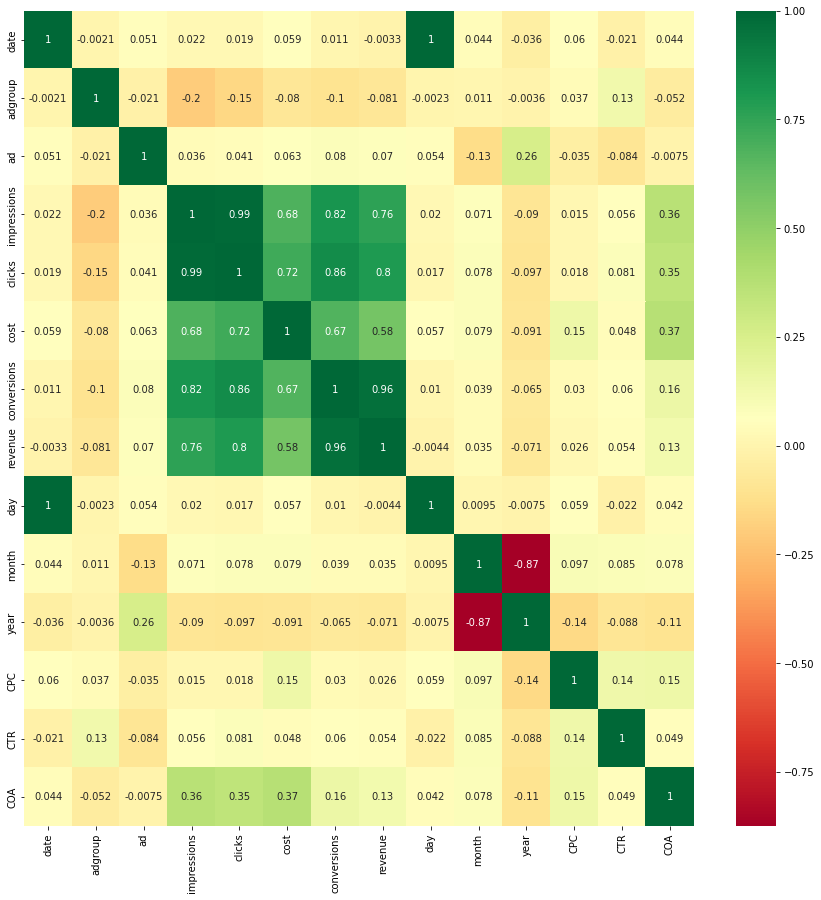

In [37]:
plt.figure(figsize=(15,15))
corrmat =train.corr()
top_corr_features = corrmat.index

#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#sns.heatmap(train.corr(),annot=True)
plt.show()

In [38]:
train[X].var().sort_values(ascending=False)

impressions    39342.618057
clicks         10033.009839
date            4311.428828
ad               373.424930
cost             206.256076
day               77.234203
conversions       27.289366
month              6.358523
COA                4.044536
adgroup            1.198460
year               0.212179
CTR                0.053852
CPC                0.018230
dtype: float64

In [39]:
#features=['COA','cost','conversions','adgroup','clicks','CPC']---v5.0
#features=['conversions','adgroup','date','clicks','year']---v11.0
features=['date', 'adgroup', 'ad', 'impressions', 'clicks', 'cost', 'conversions',
       'day', 'month', 'year', 'CPC', 'CTR', 'COA']  # replaced impression->cost
X=train[features]
y=train.revenue

#Train Test Split

In [40]:
# Since the given data is time series,we will not split on random basis...splitting data contigously
row=3320
X_train=X[:row]
X_val=X[row:]
y_train=y[:row]
y_val=y[row:]

In [41]:
X_test=test[features]

In [42]:
X_train.shape,y_val.shape

((3320, 13), (1251,))

#Model Building and Evaluation

In [43]:
def score(model,test,name='default'):
    model.fit(X_train,y_train)
    ypred=model.predict(test)
    print(name)
    print('Accuracy of training set: ',round(model.score(X_train,y_train)*100,2))
    print('Accuracy of test set: ',round(model.score(test,y_val)*100,2))
    print('mean squared error: ',round(mean_squared_error(y_val,ypred)/100,2))
    print('mean absolute error: ',round(mean_absolute_error(y_val,ypred),2))
    print('r2_score: ',round(r2_score(y_val,ypred)*100,2))

Linear Regression

In [44]:
le=LinearRegression()
score(le,X_val,name='Linear Regression')

Linear Regression
Accuracy of training set:  94.64
Accuracy of test set:  73.89
mean squared error:  371.98
mean absolute error:  113.54
r2_score:  73.89


In [45]:
le.fit(X_train,y_train)
ypred=le.predict(test[features])
preds=le.predict(X_val)

In [46]:
ypred_df=pd.DataFrame(ypred,columns=['revenue'])

In [47]:
ypred_df

,revenue
0,106.940529
1,-84.390654
2,-78.341146
3,-83.912851
4,-77.342295
...,...
313,-84.852503
314,-59.229409
315,-83.488769
316,-68.456949


In [48]:
train[features][:row].shape

(3320, 13)

XGBoost Algorithm

In [49]:
# Best hyperparameters

xgb=XGBRegressor(n_estimators=37,learning_rate=0.05,booster='gbtree')
xgb.fit(X_train,y_train)

score(xgb,X_val,name='XG Boost')

[15:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boost
Accuracy of training set:  94.29
Accuracy of test set:  91.52
mean squared error:  120.78
mean absolute error:  42.98
r2_score:  91.52


In [50]:
ypred=xgb.predict(X_test)
preds=xgb.predict(X_val)

In [51]:
ypred_df=pd.DataFrame(ypred,columns=['revenue'])

In [52]:
ypred_df.index=test.index
ypred_df.head(10)

,revenue
0,122.774246
1,7.764582
2,7.764582
3,7.764582
4,7.764582
5,7.764582
6,122.774246
7,7.764582
8,122.774246
9,7.764582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


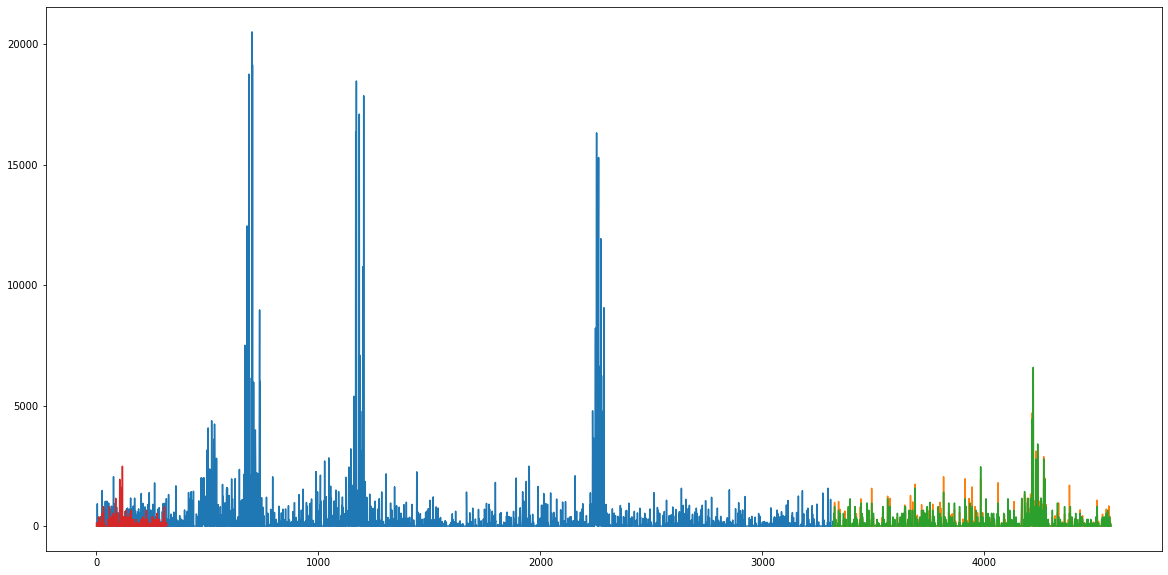

In [53]:
plt.figure(figsize=(20,10))
valid=train[row:]
valid['Predictions'] = 0
valid['Predictions'] = preds
train1=train[features][:row]
valid.index = train[features][row:].index
train1.index = train1[:row].index

plt.plot(train['revenue'][:row]) # train set
plt.plot(valid[['revenue', 'Predictions']]) # val set
plt.plot(ypred_df.revenue) # test set
plt.show()

In [54]:
#use this to find optimum value of n
mse=[]
mae=[]
for i in range(10,60):
    xgb=XGBRegressor(n_estimators=i,learning_rate=0.05)
    xgb.fit(X_train,y_train)
    pr=xgb.predict(X_val)
    ms=mean_squared_error(y_val,pr)
    ma=mean_absolute_error(y_val,pr)
    mse.append(ms)
    mae.append(ma)

[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [55]:
10+mae.index(min(mae))

37

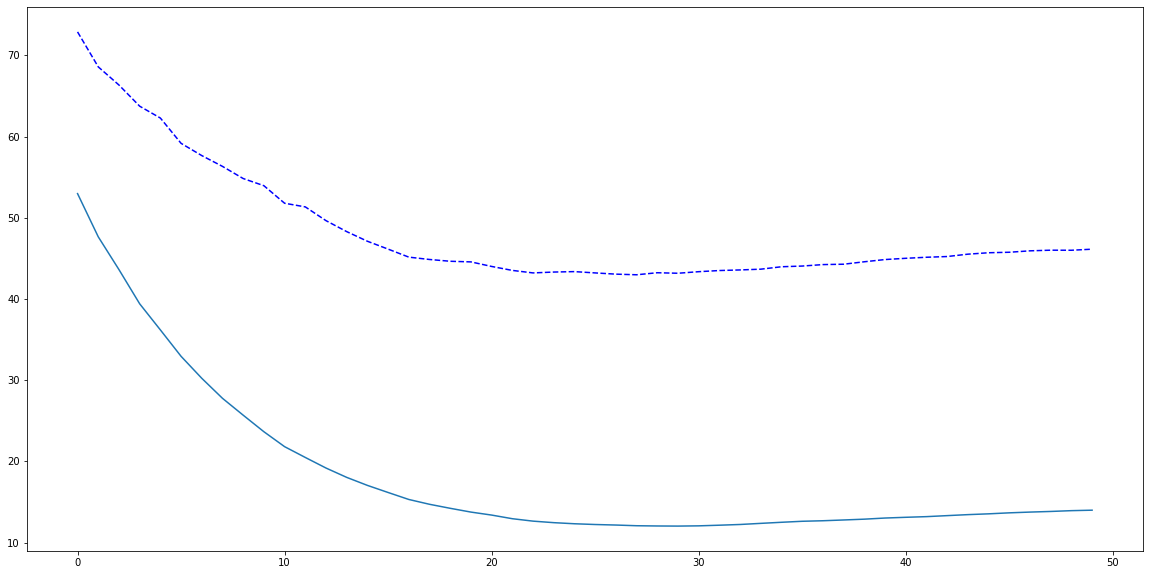

In [56]:
plt.figure(figsize=(20,10))
plt.plot(np.array(mae),'b--')
plt.plot(np.array(mse)/1000)
plt.show()

In [57]:
 xgb_model = XGBRegressor(
         objective = 'reg:squarederror',
         colsample_bytree = 0.7,
         learning_rate = 0.1,
         max_depth = 3,
         min_child_weight = 3,
         n_estimators = 60,
         subsample = 0.7)

 %time xgb_model.fit(X_train, y_train, early_stopping_rounds=7, eval_set=[(X_val, y_val)], verbose=False)

 y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb1 = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

 print("MAE: ", mae_xgb)
score(xgb_model,X_val,name='XG Boost')

CPU times: user 93.2 ms, sys: 2.96 ms, total: 96.1 ms
Wall time: 96 ms
MAE:  42.78450209792188
XG Boost
Accuracy of training set:  95.45
Accuracy of test set:  91.4
mean squared error:  122.5
mean absolute error:  42.78
r2_score:  91.4


#Hypertuning

In [58]:
 def hyperParameterTuning(X_train, y_train):
        param_tuning = {
         'learning_rate': [0.01, 0.1,0.05],
        'max_depth': [3, 5, 7, 10],
         'min_child_weight': [1, 3, 5],
         'subsample': [0.5, 0.7],
         'colsample_bytree': [0.5, 0.7],
         'n_estimators' : [40, 50, 60],
         'objective': ['reg:squarederror']
     }

        xgb_model = XGBRegressor()

        gsearch = GridSearchCV(estimator = xgb_model,
                            param_grid = param_tuning,                        
                            #scoring = 'neg_mean_absolute_error', #MAE
                            #scoring = 'neg_mean_squared_error',  #MSE
                            cv = 5,
                            n_jobs = -1,
                            verbose = 1)

        gsearch.fit(X_train,y_train)
        ypred=gsearch.predict(X_val)
        ypred_1=gsearch.predict(X_test)
        
        print('Accuracy of training set: ',round(gsearch.score(X_train,y_train)*100,2))
        print('Accuracy of test set: ',round(gsearch.score(X_val,y_val)*100,2))
        print('mean squared error: ',round(mean_squared_error(y_val,ypred)/100,2))
        print('mean absolute error: ',round(mean_absolute_error(y_val,ypred),2))
        print('r2_score: ',round(r2_score(y_val,ypred)*100,2))
        return ypred_1

In [59]:
 ypred_1 = hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Accuracy of training set:  95.58
Accuracy of test set:  88.79
mean squared error:  159.66
mean absolute error:  43.16
r2_score:  88.79


In [60]:
ypred2_df=pd.DataFrame(ypred_1,columns=['revenue'])
ypred2_df.to_csv('Submission_GridSearch.csv',index=False)

#Optuna HyperTuning

In [62]:
!pip install optuna

     |████████████████████████████████| 308 kB 24.2 MB/s 
     |████████████████████████████████| 210 kB 56.2 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 113 kB 54.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 150 kB 51.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=01e704a0855f70c5828326be951ad747abe276d0117dca7ccf2e364b8c9be7b1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [63]:
import optuna
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
dtrain = xgb.DMatrix(X_train,y_train)
dtest  = xgb.DMatrix(X_val,y_val)

In [64]:
def objective(trial):
   
    param = {
#               
                'max_depth':trial.suggest_int('max_depth', 0,12 ),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0.5,5),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0,5),
                'min_child_weight':trial.suggest_int('min_child_weight',0,4),
                'gamma':trial.suggest_uniform('gamma', 1,8 ),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.15,2),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.1,1),
                'subsample':trial.suggest_uniform('subsample',0.05,1),

                'nthread' : -1
            }
    return(return_rmse(param)) # this will return the rmse score 

In [65]:
import re
def return_rmse(params):
    model = xgb.train(params , dtrain, num_boost_round = 60, evals = [(dtest, 'eval')],
          early_stopping_rounds=20,verbose_eval = 0)
    result = model.eval(dtest)
    result = np.float(re.search(r'[\d.]+$',result).group(0))
    print(result)
    return(result)

In [66]:
study1 = optuna.create_study(direction='minimize',sampler=TPESampler())
study1.optimize(objective, n_trials= 60,show_progress_bar = True)

[I 2022-03-15 15:46:57,685] A new study created in memory with name: no-name-daa88526-6838-42fc-914f-4bba8e86d24b
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


121.357872
[I 2022-03-15 15:46:57,944] Trial 0 finished with value: 121.357872 and parameters: {'max_depth': 4, 'reg_alpha': 2.8740088659765903, 'reg_lambda': 2.6906670713879155, 'min_child_weight': 1, 'gamma': 7.642240818304922, 'learning_rate': 0.18729930087177063, 'colsample_bytree': 0.6296345341139399, 'subsample': 0.2989697153850992}. Best is trial 0 with value: 121.357872.
143.09819
[I 2022-03-15 15:46:58,087] Trial 1 finished with value: 143.09819 and parameters: {'max_depth': 7, 'reg_alpha': 0.5763484416849451, 'reg_lambda': 4.945947728076924, 'min_child_weight': 3, 'gamma': 4.828012962714259, 'learning_rate': 0.3069554358720159, 'colsample_bytree': 0.24799865723737277, 'subsample': 0.37536186154624207}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


171.625153
[I 2022-03-15 15:46:58,265] Trial 2 finished with value: 171.625153 and parameters: {'max_depth': 10, 'reg_alpha': 3.208849489650769, 'reg_lambda': 1.1285454785524678, 'min_child_weight': 2, 'gamma': 3.6758175015182553, 'learning_rate': 0.21790319119699572, 'colsample_bytree': 0.4313009941393633, 'subsample': 0.3145044470521735}. Best is trial 0 with value: 121.357872.
434.760712
[I 2022-03-15 15:46:58,332] Trial 3 finished with value: 434.760712 and parameters: {'max_depth': 0, 'reg_alpha': 1.9796022551488202, 'reg_lambda': 4.146088172104998, 'min_child_weight': 0, 'gamma': 5.332582073724722, 'learning_rate': 0.7012782364205941, 'colsample_bytree': 0.5728030740595667, 'subsample': 0.1653241061533713}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias f

128.97551
[I 2022-03-15 15:46:58,541] Trial 4 finished with value: 128.97551 and parameters: {'max_depth': 11, 'reg_alpha': 4.176487262868372, 'reg_lambda': 4.658674112947752, 'min_child_weight': 1, 'gamma': 7.491608573654476, 'learning_rate': 0.36942137524801244, 'colsample_bytree': 0.7881589990842351, 'subsample': 0.9261753408329862}. Best is trial 0 with value: 121.357872.
11203.174805
[I 2022-03-15 15:46:58,620] Trial 5 finished with value: 11203.174805 and parameters: {'max_depth': 4, 'reg_alpha': 1.0775006030749124, 'reg_lambda': 0.480296726400794, 'min_child_weight': 4, 'gamma': 6.776031295876496, 'learning_rate': 1.6393940370257039, 'colsample_bytree': 0.40225913072770025, 'subsample': 0.23610166575437846}. Best is trial 0 with value: 121.357872.
194.060593
[I 2022-03-15 15:46:58,733] Trial 6 finished with value: 194.060593 and parameters: {'max_depth': 2, 'reg_alpha': 1.819284844201201, 'reg_lambda': 0.44228560250739624, 'min_child_weight': 4, 'gamma': 1.5237272227698928, 'lea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias f

188.567032
[I 2022-03-15 15:46:58,829] Trial 7 finished with value: 188.567032 and parameters: {'max_depth': 4, 'reg_alpha': 4.688553193542091, 'reg_lambda': 0.5024978302313188, 'min_child_weight': 1, 'gamma': 7.043594059199519, 'learning_rate': 0.5808780866527282, 'colsample_bytree': 0.41366052724977376, 'subsample': 0.48624507055059357}. Best is trial 0 with value: 121.357872.
488.815216
[I 2022-03-15 15:46:58,921] Trial 8 finished with value: 488.815216 and parameters: {'max_depth': 8, 'reg_alpha': 3.6625303144461503, 'reg_lambda': 0.9810821860609653, 'min_child_weight': 4, 'gamma': 7.727260596254134, 'learning_rate': 0.8355288867971014, 'colsample_bytree': 0.9535584695415028, 'subsample': 0.08656337922947813}. Best is trial 0 with value: 121.357872.
401.604401
[I 2022-03-15 15:46:58,987] Trial 9 finished with value: 401.604401 and parameters: {'max_depth': 0, 'reg_alpha': 2.3488966291379687, 'reg_lambda': 0.3822247062355433, 'min_child_weight': 3, 'gamma': 6.511523041394208, 'learn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


122.523773
[I 2022-03-15 15:46:59,151] Trial 10 finished with value: 122.523773 and parameters: {'max_depth': 5, 'reg_alpha': 3.22105321459263, 'reg_lambda': 2.856514633408523, 'min_child_weight': 0, 'gamma': 3.2218509818072802, 'learning_rate': 0.15251788770155764, 'colsample_bytree': 0.7045793292767799, 'subsample': 0.6805025729205876}. Best is trial 0 with value: 121.357872.
122.971397
[I 2022-03-15 15:46:59,314] Trial 11 finished with value: 122.971397 and parameters: {'max_depth': 5, 'reg_alpha': 3.0423235425137274, 'reg_lambda': 2.7419939367964985, 'min_child_weight': 0, 'gamma': 2.929190904745263, 'learning_rate': 0.1722258435272051, 'colsample_bytree': 0.6796843326396723, 'subsample': 0.6714450247154072}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


123.233856
[I 2022-03-15 15:46:59,437] Trial 12 finished with value: 123.233856 and parameters: {'max_depth': 3, 'reg_alpha': 3.5462862411573157, 'reg_lambda': 2.8536318456982923, 'min_child_weight': 1, 'gamma': 2.276543467142813, 'learning_rate': 0.15074890089365953, 'colsample_bytree': 0.8421026076783568, 'subsample': 0.674550310799767}. Best is trial 0 with value: 121.357872.
138.017654
[I 2022-03-15 15:46:59,567] Trial 13 finished with value: 138.017654 and parameters: {'max_depth': 6, 'reg_alpha': 2.5298186568419667, 'reg_lambda': 1.981534441826569, 'min_child_weight': 0, 'gamma': 4.021337127523997, 'learning_rate': 0.2932952363883413, 'colsample_bytree': 0.6531535437746026, 'subsample': 0.6657401866078432}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


137.031265
[I 2022-03-15 15:46:59,786] Trial 14 finished with value: 137.031265 and parameters: {'max_depth': 8, 'reg_alpha': 4.059341052661293, 'reg_lambda': 3.534912219776878, 'min_child_weight': 1, 'gamma': 5.613863497813739, 'learning_rate': 0.2253643840542124, 'colsample_bytree': 0.7698324359544992, 'subsample': 0.49859770820897664}. Best is trial 0 with value: 121.357872.
130.303726
[I 2022-03-15 15:46:59,883] Trial 15 finished with value: 130.303726 and parameters: {'max_depth': 2, 'reg_alpha': 4.888553795649328, 'reg_lambda': 1.8031384251644451, 'min_child_weight': 2, 'gamma': 2.920937718323846, 'learning_rate': 0.3656316380871343, 'colsample_bytree': 0.9657875481888175, 'subsample': 0.77080269267319}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


135.249023
[I 2022-03-15 15:47:00,021] Trial 16 finished with value: 135.249023 and parameters: {'max_depth': 6, 'reg_alpha': 2.8235199725184055, 'reg_lambda': 3.4691682193595943, 'min_child_weight': 0, 'gamma': 1.1767925672673232, 'learning_rate': 0.21973672007830458, 'colsample_bytree': 0.5992142923844042, 'subsample': 0.5530679341218494}. Best is trial 0 with value: 121.357872.
230.571777
[I 2022-03-15 15:47:00,167] Trial 17 finished with value: 230.571777 and parameters: {'max_depth': 9, 'reg_alpha': 1.5828947090670302, 'reg_lambda': 2.167144862250257, 'min_child_weight': 1, 'gamma': 5.692466631577397, 'learning_rate': 0.41605076307470307, 'colsample_bytree': 0.7091876535689418, 'subsample': 0.05130322619526212}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


138.524429
[I 2022-03-15 15:47:00,484] Trial 18 finished with value: 138.524429 and parameters: {'max_depth': 12, 'reg_alpha': 3.438810767857136, 'reg_lambda': 3.3825839935309787, 'min_child_weight': 2, 'gamma': 4.109921844215865, 'learning_rate': 0.1526957074968985, 'colsample_bytree': 0.8706523802964237, 'subsample': 0.8180802800467455}. Best is trial 0 with value: 121.357872.
138.828339
[I 2022-03-15 15:47:00,623] Trial 19 finished with value: 138.828339 and parameters: {'max_depth': 2, 'reg_alpha': 2.297698920122339, 'reg_lambda': 2.5001046695520763, 'min_child_weight': 0, 'gamma': 3.3344282589690732, 'learning_rate': 0.2529291671439544, 'colsample_bytree': 0.31114883102095486, 'subsample': 0.2523874273954938}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


161.799423
[I 2022-03-15 15:47:00,727] Trial 20 finished with value: 161.799423 and parameters: {'max_depth': 5, 'reg_alpha': 3.880665082348024, 'reg_lambda': 1.5035127672720758, 'min_child_weight': 2, 'gamma': 4.628480921914246, 'learning_rate': 0.4506066479910941, 'colsample_bytree': 0.4890050146243339, 'subsample': 0.5771645635210161}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


121.385544
[I 2022-03-15 15:47:00,966] Trial 21 finished with value: 121.385544 and parameters: {'max_depth': 5, 'reg_alpha': 2.991165534250373, 'reg_lambda': 2.9497494675708804, 'min_child_weight': 0, 'gamma': 2.3185518455444285, 'learning_rate': 0.17306510041677495, 'colsample_bytree': 0.6604359608175813, 'subsample': 0.6766151789124654}. Best is trial 0 with value: 121.357872.
125.495674
[I 2022-03-15 15:47:01,095] Trial 22 finished with value: 125.495674 and parameters: {'max_depth': 4, 'reg_alpha': 2.87644500357497, 'reg_lambda': 3.071380080742041, 'min_child_weight': 0, 'gamma': 2.169402913597117, 'learning_rate': 0.18705523544974748, 'colsample_bytree': 0.6153556361908502, 'subsample': 0.7762988341775573}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


128.154282
[I 2022-03-15 15:47:01,266] Trial 23 finished with value: 128.154282 and parameters: {'max_depth': 5, 'reg_alpha': 3.257148443721223, 'reg_lambda': 4.041487595957251, 'min_child_weight': 1, 'gamma': 2.681712119759617, 'learning_rate': 0.18864812167867065, 'colsample_bytree': 0.7375628453571109, 'subsample': 0.42983095074947303}. Best is trial 0 with value: 121.357872.
149.729813
[I 2022-03-15 15:47:01,395] Trial 24 finished with value: 149.729813 and parameters: {'max_depth': 7, 'reg_alpha': 4.3503049525204585, 'reg_lambda': 2.3120135283104477, 'min_child_weight': 0, 'gamma': 1.8736257189240024, 'learning_rate': 0.27642551502975765, 'colsample_bytree': 0.5249440738243798, 'subsample': 0.6493571772532668}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


129.778687
[I 2022-03-15 15:47:01,507] Trial 25 finished with value: 129.778687 and parameters: {'max_depth': 3, 'reg_alpha': 2.6699555555204353, 'reg_lambda': 3.935570263286129, 'min_child_weight': 1, 'gamma': 3.492348103277842, 'learning_rate': 0.20053064909034718, 'colsample_bytree': 0.8910349075804221, 'subsample': 0.8236930662398576}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


125.81485
[I 2022-03-15 15:47:01,746] Trial 26 finished with value: 125.81485 and parameters: {'max_depth': 6, 'reg_alpha': 2.2047099825981586, 'reg_lambda': 3.0511189633598756, 'min_child_weight': 0, 'gamma': 1.0249670481745898, 'learning_rate': 0.15256484591768588, 'colsample_bytree': 0.667276679618719, 'subsample': 0.6029491319346967}. Best is trial 0 with value: 121.357872.
215.166
[I 2022-03-15 15:47:01,867] Trial 27 finished with value: 215.166 and parameters: {'max_depth': 3, 'reg_alpha': 3.14770922661496, 'reg_lambda': 2.5758247975535364, 'min_child_weight': 1, 'gamma': 2.422815721399145, 'learning_rate': 1.0346661755675546, 'colsample_bytree': 0.8095876599016925, 'subsample': 0.7361487059115536}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


143.446121
[I 2022-03-15 15:47:01,972] Trial 28 finished with value: 143.446121 and parameters: {'max_depth': 1, 'reg_alpha': 1.2873187325028417, 'reg_lambda': 1.7732165426193778, 'min_child_weight': 0, 'gamma': 6.118467686937899, 'learning_rate': 0.2645543951457187, 'colsample_bytree': 0.6178805728269685, 'subsample': 0.999423403108645}. Best is trial 0 with value: 121.357872.
145.108963
[I 2022-03-15 15:47:02,096] Trial 29 finished with value: 145.108963 and parameters: {'max_depth': 7, 'reg_alpha': 3.71648379044001, 'reg_lambda': 4.974423759225017, 'min_child_weight': 3, 'gamma': 5.14288724722423, 'learning_rate': 0.3422944210184983, 'colsample_bytree': 0.3306577406299871, 'subsample': 0.46268571429188504}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


135.866928
[I 2022-03-15 15:47:02,220] Trial 30 finished with value: 135.866928 and parameters: {'max_depth': 5, 'reg_alpha': 0.7253601332214541, 'reg_lambda': 3.2211878224197052, 'min_child_weight': 0, 'gamma': 4.213482416625881, 'learning_rate': 0.4793279676412578, 'colsample_bytree': 0.7469348065304451, 'subsample': 0.37751605879524414}. Best is trial 0 with value: 121.357872.
125.973251
[I 2022-03-15 15:47:02,370] Trial 31 finished with value: 125.973251 and parameters: {'max_depth': 5, 'reg_alpha': 2.9622741850859042, 'reg_lambda': 2.7658159443341535, 'min_child_weight': 0, 'gamma': 3.028598314817841, 'learning_rate': 0.1769886718243043, 'colsample_bytree': 0.6710839601691028, 'subsample': 0.7111164054854195}. Best is trial 0 with value: 121.357872.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


130.086853
[I 2022-03-15 15:47:02,563] Trial 32 finished with value: 130.086853 and parameters: {'max_depth': 7, 'reg_alpha': 3.014842963498322, 'reg_lambda': 3.7383894088564116, 'min_child_weight': 0, 'gamma': 1.8483776823855216, 'learning_rate': 0.2355087272244431, 'colsample_bytree': 0.5435457361118774, 'subsample': 0.6125531215297849}. Best is trial 0 with value: 121.357872.
118.663002
[I 2022-03-15 15:47:02,705] Trial 33 finished with value: 118.663002 and parameters: {'max_depth': 4, 'reg_alpha': 3.2605823655100337, 'reg_lambda': 2.8450810500385133, 'min_child_weight': 1, 'gamma': 3.722407424218715, 'learning_rate': 0.17810748460545303, 'colsample_bytree': 0.7289888280994584, 'subsample': 0.5406291254747935}. Best is trial 33 with value: 118.663002.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


134.396896
[I 2022-03-15 15:47:02,858] Trial 34 finished with value: 134.396896 and parameters: {'max_depth': 4, 'reg_alpha': 3.2843560302280315, 'reg_lambda': 4.393799854519563, 'min_child_weight': 1, 'gamma': 3.546018302185457, 'learning_rate': 0.20312604645073615, 'colsample_bytree': 0.7226092457467173, 'subsample': 0.32365979027938174}. Best is trial 33 with value: 118.663002.
136.16539
[I 2022-03-15 15:47:02,955] Trial 35 finished with value: 136.16539 and parameters: {'max_depth': 3, 'reg_alpha': 2.576500942375679, 'reg_lambda': 2.3036792646314437, 'min_child_weight': 2, 'gamma': 3.836957428906377, 'learning_rate': 0.3105386019409066, 'colsample_bytree': 0.5715424786919077, 'subsample': 0.5441442109963036}. Best is trial 33 with value: 118.663002.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


130.675552
[I 2022-03-15 15:47:03,079] Trial 36 finished with value: 130.675552 and parameters: {'max_depth': 4, 'reg_alpha': 2.0411987158388487, 'reg_lambda': 2.8442547163764846, 'min_child_weight': 2, 'gamma': 4.369123007779349, 'learning_rate': 0.17220669279432238, 'colsample_bytree': 0.8102317354027622, 'subsample': 0.17492512370846997}. Best is trial 33 with value: 118.663002.
136.843491
[I 2022-03-15 15:47:03,226] Trial 37 finished with value: 136.843491 and parameters: {'max_depth': 6, 'reg_alpha': 3.4537038243024503, 'reg_lambda': 3.6953956576674165, 'min_child_weight': 1, 'gamma': 7.29816927303898, 'learning_rate': 0.24250208059921471, 'colsample_bytree': 0.47480247483491045, 'subsample': 0.427523009590723}. Best is trial 33 with value: 118.663002.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


132.287216
[I 2022-03-15 15:47:03,376] Trial 38 finished with value: 132.287216 and parameters: {'max_depth': 1, 'reg_alpha': 4.25535670759275, 'reg_lambda': 1.1707047876222392, 'min_child_weight': 1, 'gamma': 4.738134649545748, 'learning_rate': 0.16897920942833233, 'colsample_bytree': 0.6306240308328589, 'subsample': 0.28163739016146344}. Best is trial 33 with value: 118.663002.
149.572556
[I 2022-03-15 15:47:03,573] Trial 39 finished with value: 149.572556 and parameters: {'max_depth': 8, 'reg_alpha': 3.781907835385022, 'reg_lambda': 0.038807304375414464, 'min_child_weight': 1, 'gamma': 7.869050895744361, 'learning_rate': 0.2067569762290789, 'colsample_bytree': 0.9198799623631488, 'subsample': 0.8505446490384047}. Best is trial 33 with value: 118.663002.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


118.662704
[I 2022-03-15 15:47:03,746] Trial 40 finished with value: 118.662704 and parameters: {'max_depth': 4, 'reg_alpha': 1.8200109846926793, 'reg_lambda': 3.1083566451202795, 'min_child_weight': 0, 'gamma': 4.987088748672832, 'learning_rate': 0.15048296629825578, 'colsample_bytree': 0.7067263593972778, 'subsample': 0.5186569977896651}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias f

120.958115
[I 2022-03-15 15:47:03,987] Trial 41 finished with value: 120.958115 and parameters: {'max_depth': 4, 'reg_alpha': 1.7226581930997438, 'reg_lambda': 3.1163289711072206, 'min_child_weight': 0, 'gamma': 5.104304692391707, 'learning_rate': 0.15386448204227643, 'colsample_bytree': 0.7026275662135222, 'subsample': 0.5169352468110417}. Best is trial 40 with value: 118.662704.
1068.38208
[I 2022-03-15 15:47:04,064] Trial 42 finished with value: 1068.38208 and parameters: {'max_depth': 4, 'reg_alpha': 1.507053861052888, 'reg_lambda': 3.2547600734854245, 'min_child_weight': 0, 'gamma': 5.131510897902414, 'learning_rate': 1.983334285954769, 'colsample_bytree': 0.12460916521846926, 'subsample': 0.5094694348258795}. Best is trial 40 with value: 118.662704.
128.999908
[I 2022-03-15 15:47:04,175] Trial 43 finished with value: 128.999908 and parameters: {'max_depth': 2, 'reg_alpha': 1.7427534814471701, 'reg_lambda': 3.107879321507034, 'min_child_weight': 0, 'gamma': 6.467027245014029, 'lea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


119.840363
[I 2022-03-15 15:47:04,287] Trial 44 finished with value: 119.840363 and parameters: {'max_depth': 3, 'reg_alpha': 0.8822223310266346, 'reg_lambda': 2.4590031175377125, 'min_child_weight': 1, 'gamma': 5.887070309496347, 'learning_rate': 0.19189608537501018, 'colsample_bytree': 0.5816460712714707, 'subsample': 0.3129309116004071}. Best is trial 40 with value: 118.662704.
120.343529
[I 2022-03-15 15:47:04,398] Trial 45 finished with value: 120.343529 and parameters: {'max_depth': 3, 'reg_alpha': 0.6091604679119103, 'reg_lambda': 2.533236529641951, 'min_child_weight': 1, 'gamma': 5.72562778066294, 'learning_rate': 0.2177689827132716, 'colsample_bytree': 0.5718357855334032, 'subsample': 0.33161419963966593}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


135.438416
[I 2022-03-15 15:47:04,541] Trial 46 finished with value: 135.438416 and parameters: {'max_depth': 1, 'reg_alpha': 0.8198761119719338, 'reg_lambda': 2.545999943154124, 'min_child_weight': 1, 'gamma': 5.9585850938179306, 'learning_rate': 0.2166571596338679, 'colsample_bytree': 0.5767537198625762, 'subsample': 0.19529896603550845}. Best is trial 40 with value: 118.662704.
140.027924
[I 2022-03-15 15:47:04,635] Trial 47 finished with value: 140.027924 and parameters: {'max_depth': 3, 'reg_alpha': 1.0223965077497337, 'reg_lambda': 2.247833444027227, 'min_child_weight': 1, 'gamma': 5.390399537305938, 'learning_rate': 0.32533070355284777, 'colsample_bytree': 0.519499777947437, 'subsample': 0.3352987220715127}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


135.503204
[I 2022-03-15 15:47:04,777] Trial 48 finished with value: 135.503204 and parameters: {'max_depth': 2, 'reg_alpha': 0.5954911341545481, 'reg_lambda': 2.059048041444339, 'min_child_weight': 3, 'gamma': 4.975266422820832, 'learning_rate': 0.19314826820543252, 'colsample_bytree': 0.4362957639375772, 'subsample': 0.34460785555803747}. Best is trial 40 with value: 118.662704.
177.590607
[I 2022-03-15 15:47:04,929] Trial 49 finished with value: 177.590607 and parameters: {'max_depth': 3, 'reg_alpha': 1.1126203517086388, 'reg_lambda': 1.828618892236155, 'min_child_weight': 2, 'gamma': 6.103251298942109, 'learning_rate': 0.7523156078540832, 'colsample_bytree': 0.7846070144825128, 'subsample': 0.3994761424240151}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


125.87587
[I 2022-03-15 15:47:05,072] Trial 50 finished with value: 125.87587 and parameters: {'max_depth': 4, 'reg_alpha': 0.5178106093558432, 'reg_lambda': 2.6718733946656648, 'min_child_weight': 1, 'gamma': 6.691548727135741, 'learning_rate': 0.15116818117291098, 'colsample_bytree': 0.839174870574818, 'subsample': 0.1302922023973576}. Best is trial 40 with value: 118.662704.
127.510483
[I 2022-03-15 15:47:05,205] Trial 51 finished with value: 127.510483 and parameters: {'max_depth': 4, 'reg_alpha': 1.320328712919895, 'reg_lambda': 2.3951479353662113, 'min_child_weight': 1, 'gamma': 5.5989016501013955, 'learning_rate': 0.22978725390999258, 'colsample_bytree': 0.7048214531711666, 'subsample': 0.2793989985568281}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


120.488838
[I 2022-03-15 15:47:05,327] Trial 52 finished with value: 120.488838 and parameters: {'max_depth': 3, 'reg_alpha': 0.9162239962458884, 'reg_lambda': 3.32126711290622, 'min_child_weight': 2, 'gamma': 7.406070027487616, 'learning_rate': 0.18952248187071957, 'colsample_bytree': 0.5877163451633494, 'subsample': 0.4665042813850239}. Best is trial 40 with value: 118.662704.
146.820236
[I 2022-03-15 15:47:05,429] Trial 53 finished with value: 146.820236 and parameters: {'max_depth': 2, 'reg_alpha': 0.8971612489022592, 'reg_lambda': 3.5895077853467736, 'min_child_weight': 2, 'gamma': 7.15466790059542, 'learning_rate': 0.2848734889883118, 'colsample_bytree': 0.5812297513571567, 'subsample': 0.4783337479731311}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias f

125.203331
[I 2022-03-15 15:47:05,555] Trial 54 finished with value: 125.203331 and parameters: {'max_depth': 3, 'reg_alpha': 1.2042314727386856, 'reg_lambda': 3.35629108020569, 'min_child_weight': 3, 'gamma': 6.454599275022893, 'learning_rate': 0.187905418783239, 'colsample_bytree': 0.6316563958186667, 'subsample': 0.5322232324721234}. Best is trial 40 with value: 118.662704.
411.266693
[I 2022-03-15 15:47:05,620] Trial 55 finished with value: 411.266693 and parameters: {'max_depth': 0, 'reg_alpha': 1.492151506186411, 'reg_lambda': 2.943755415449176, 'min_child_weight': 4, 'gamma': 4.5279313144777324, 'learning_rate': 0.24982386072441365, 'colsample_bytree': 0.6881413148909656, 'subsample': 0.5787679701837729}. Best is trial 40 with value: 118.662704.
133.347504
[I 2022-03-15 15:47:05,744] Trial 56 finished with value: 133.347504 and parameters: {'max_depth': 1, 'reg_alpha': 1.887330220477997, 'reg_lambda': 3.2799099587308715, 'min_child_weight': 2, 'gamma': 5.8245018576833125, 'learn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


128.451309
[I 2022-03-15 15:47:05,891] Trial 57 finished with value: 128.451309 and parameters: {'max_depth': 2, 'reg_alpha': 0.6968151257744373, 'reg_lambda': 4.3465705306973295, 'min_child_weight': 2, 'gamma': 7.537448658826454, 'learning_rate': 0.21424294554841136, 'colsample_bytree': 0.49329886867139117, 'subsample': 0.463154928403178}. Best is trial 40 with value: 118.662704.
155.092667
[I 2022-03-15 15:47:06,086] Trial 58 finished with value: 155.092667 and parameters: {'max_depth': 4, 'reg_alpha': 1.0490033960425085, 'reg_lambda': 2.6625899631409595, 'min_child_weight': 1, 'gamma': 5.375143200034663, 'learning_rate': 0.18746725305043818, 'colsample_bytree': 0.390257473080323, 'subsample': 0.36649296894427597}. Best is trial 40 with value: 118.662704.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


124.815948
[I 2022-03-15 15:47:06,219] Trial 59 finished with value: 124.815948 and parameters: {'max_depth': 3, 'reg_alpha': 0.8813774826328475, 'reg_lambda': 3.849789472072981, 'min_child_weight': 0, 'gamma': 4.973979252485044, 'learning_rate': 0.16170850978243176, 'colsample_bytree': 0.6485031757143039, 'subsample': 0.5020205307076526}. Best is trial 40 with value: 118.662704.


In [67]:
study1.best_params
#model(study1.best_params)

{'colsample_bytree': 0.7067263593972778,
 'gamma': 4.987088748672832,
 'learning_rate': 0.15048296629825578,
 'max_depth': 4,
 'min_child_weight': 0,
 'reg_alpha': 1.8200109846926793,
 'reg_lambda': 3.1083566451202795,
 'subsample': 0.5186569977896651}

In [68]:
optuna.visualization.plot_optimization_history(study1)

In [69]:
optuna.visualization.plot_slice(study1)

In [70]:
xgb_model = XGBRegressor(**(study1.best_params))

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=7, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb2 = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print("MAE: ", mae_xgb)
score(xgb_model,X_val,name='XG Boost')

[15:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 106 ms, sys: 1.77 ms, total: 107 ms
Wall time: 110 ms
MAE:  45.030403901732136
[15:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boost
Accuracy of training set:  96.6
Accuracy of test set:  90.58
mean squared error:  134.17
mean absolute error:  45.03
r2_score:  90.58


In [71]:
ypred2_df=pd.DataFrame(y_pred_xgb2,columns=['revenue'])
ypred2_df.to_csv('Submission_optuna.csv',index=False)

#Random Forest Regressor

In [72]:
rf=RandomForestRegressor(n_estimators=25,max_depth=5)
rf.fit(X_train,y_train)
ypredrf=rf.predict(test[features])
score(rf,X_val,name='Random Forest')

Random Forest
Accuracy of training set:  98.23
Accuracy of test set:  83.41
mean squared error:  236.36
mean absolute error:  50.21
r2_score:  83.41


In [73]:
ypred_df=pd.DataFrame(ypredrf,columns=['revenue'])
ypred_df.head(10)

,revenue
0,169.262379
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,169.262379
7,0.000000
8,169.262379
9,0.000000


In [74]:
ypred_df.to_csv('Submission_RF.csv',index=False)